# 입문자를 위한, 파이썬/R 데이터 분석   

## Part(1) - Day05  : 

]

## Today's mission

- (고급분석) 타이타닉호의 생존자 가려내기

]

# (고급분석) 타이타닉호의 생존자 가려내기

Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

### 바로가기

- [<Step1. 탐색> : Titanic 데이터 살펴보기](#<Step1.-탐색>-:-Titanic-데이터-살펴보기)
    - [Titanic 데이터셋의 기본 정보]
    - [탐색적 데이터 분석]
- [<Step2. 분류> : 생존자 분류 모델 만들기](#<Step2.-분류>-:-생존자-분류-모델-만들기)
    - [분류 모델을 위한 전처리]
    - [분류 모델링]
- [<Step3. 모델 개선> : 피처 엔지니어링 첫걸음](#<Step3.-모델-개선>-:-피처-엔지니어링-첫걸음)
    - [피처에서 새로운 의미 추출해내기]
    - [피처 스케일링]
    - [피처 영향력 살펴보기]
- [<Step4. 평가> : 모델 검증하기](#<Step4.-평가>-:-모델-검증하기)
    - [K-fold 교차 검증 수행하기]
    - [학습 곡선 분석하기]

In [ ]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : Titanic 데이터 살펴보기

### [Titanic 데이터셋의 기본 정보]

##### 데이터 피처 설명
- pclass : Passenger Class, 승객 등급
- survived : 생존 여부
- name : 승객 이름
- sex : 승객 성별
- age : 승객 나이
- sibsp : 탑승 한 형제/배우자 수
- parch : 탑승 한 부모/자녀 수
- ticket : 티켓 번호
- fare : 승객 지불 요금
- cabin : 선실 이름
- embarked : 승선항 (C = 쉘 부르그, Q = 퀸즈타운, S = 사우스 햄튼)
- body : 사망자 확인 번호
- home.dest : 고향/목적지

##### 도메인 지식 :  [타이타닉 침몰사고](https://ko.wikipedia.org/wiki/RMS_%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89)

​ 타이타닉 생존자 분석하기에 앞서 도움을 주는 도메인지식이 있다. 간단하게 요약해보자 한다.

- 1912년 시대적 배경에는 “Lady First”라는 개념이 존재 했다. 
- 어린이와 여자부터 우선적으로 구조 했다고 한다. 
- “Lady First”라는 개념이 없었다면 급박한 상황에서 구명정으로 달려들때 힘센 남성이 구명정을 차지할 가능성이 높아 생존에 유리했을 것이다.
- 타이타닉호에는 쉽게말해 사회적위치가 높은 사람, 부자, 일반인, 가난한 이민자 등 여러 부류 사람들이 있었고, 객실도 1등실~3등실이 있었다.
- 3등실은 여러 구역이 철창으로 막혀 제한되어 있었고 배가 미로처럼 복잡했기 때문에 탈출에 지장을 빚었으며, 3등실은 승객들 중에는 영어를 잘 하지 못하는 승객들도 많았다

In [ ]:
df_train = pd.read_csv("data_titanic_adv/titanic_train.csv")
df_test = pd.read_csv("data_titanic_adv/titanic_test.csv")

In [ ]:
df_train.describe()

In [ ]:
df_test.describe()

In [ ]:
df_train.tail(5)

In [ ]:
df_test.head(5)

In [ ]:
print(df_train.info())
print("---------------------------------")
print(df_test.info())

##### 불필요한 피처 제거

In [ ]:
# 데이터셋에서 name, ticket, body, cabin, home.dest 피처를 제거합니다.
df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)

### [탐색적 데이터 분석]

In [ ]:
print(df_train['survived'].value_counts())

In [ ]:
df_train['survived'].value_counts().plot.bar()

In [ ]:
# survived 피처를 기준으로 그룹을 나누어, 그룹별 pclass 피처의 분포를 살펴봅니다.
print(df_train['pclass'].value_counts())

In [ ]:
ax = sns.countplot(x='pclass', hue = 'survived',  data = df_train)

In [ ]:
from scipy import stats

# 두 집단의 피처를 비교해주며 탐색작업을 자동화하는 함수를 정의합니다.
def valid_features(df, col_name, distribution_check=True):
    
    # 두 집단 (survived=1, survived=0)의 분포 그래프를 출력합니다.
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)

    # 두 집단 (survived=1, survived=0)의 표준편차를 각각 출력합니다.
    titanic_survived = df[df['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_survived_static))
    titanic_n_survived = df[df['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_n_survived_static))
    
     # T-test로 두 집단의 평균 차이를 검정합니다. (타겟 구분)
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)
    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f." % tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f" % tTestResultDiffVar)
    
    if distribution_check:
        # Shapiro-Wilk 검정 : 주어진 데이터가 얼마나 정규성을 따르는지 측정하는 검정 방법.(전체 데이터)
        print("The w-statistic and p-value in Survived %.3f and %.3f" % stats.shapiro(titanic_survived[col_name]))
        print("The w-statistic and p-value in Non-Survived %.3f and %.3f" % stats.shapiro(titanic_n_survived[col_name]))

- 참고 : T-test 검정 : https://brunch.co.kr/@jihoonleeh9l6/33

- 참고 : 편차, 분산, 표준편차 : https://ko.wikipedia.org/wiki/%ED%91%9C%EC%A4%80_%ED%8E%B8%EC%B0%A8

In [ ]:
#df_train[df_train['age'] > 0]

In [ ]:
# 앞서 정의한 valid_features 함수를 실행합니다. age 피처를 탐색합니다.
# p-value가 0.5 이상이므로 이 두 집단은 거의 차이가 없다
# w통계량의 p-value가 낮으므로 정규성을 따른다
valid_features(df_train[df_train['age'] > 0], 'age', distribution_check=True)

In [ ]:
# 앞서 정의한 valid_features 함수를 실행합니다. sibsp 피처를 탐색합니다.
valid_features(df_train, 'sibsp', distribution_check=True)

In [ ]:
# 앞서 정의한 valid_features 함수를 실행합니다. sibsp 피처를 탐색합니다.
valid_features(df_train, 'pclass', distribution_check=True)

### `[미니 퀴즈 - 4.1]`
- `parch, fare, sex, embarked 피처에 대해 (생존자/비생존자) 간의 차이를 탐색해 보세요.` 
    - 위에서와 동일한 방법를 이용하여 생존자와 비생존자 그룹간의 평균과 분포가 어떻게 다른지, 혹은 통계적 유의성이 얼마나 있는지 대해 살펴보도록 합시다.
        - sex : 남/여에서 생존자와 비생존자간의 비율이 크게 다른것을 확인할 수 있습니다.
        - embarked : 3개의 승선항에 따라 생존자와 비생존자간의 비율이 부분적으로 다른것을 확인할 수 있습니다.
        - parch : 편차에 약간 차이가 있고, t-test 결과 두 집단의 평균에도 약간의 차이가 있다는 것을 알 수 있습니다.
        - fare : 편차에 많은 차이가 있고, t-test 결과 두 집단의 평균은 다르다고 확신할 수 있습니다.

In [ ]:
ax = sns.countplot(x='sex', hue = 'survived',  data = df_train)

In [ ]:
ax = sns.countplot(x='embarked', hue = 'survived',  data = df_train)

In [ ]:
valid_features(df_train, 'parch', distribution_check=True)

In [ ]:
valid_features(df_train, 'fare', distribution_check=True)

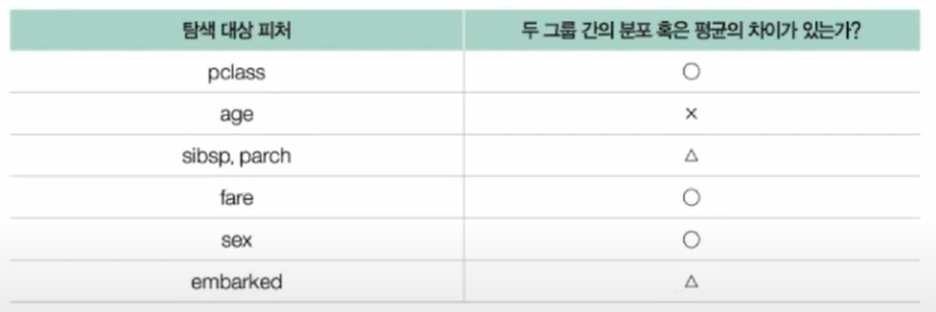

# <Step2. 분류> : 생존자 분류 모델 만들기

### [분류 모델을 위한 전처리]

In [ ]:
df_train.describe()

In [ ]:
# age의 결측값을 평균값으로 대체합니다.
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

In [ ]:
 df_train['embarked'].value_counts()

In [ ]:
df_train['embarked'].value_counts().index[0]

In [ ]:
# embark : 2개의 결측값을 최빈값으로 대체합니다.
embarked_mode = df_train['embarked'].value_counts().index[0]
embarked_mode

In [ ]:
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

In [ ]:
# one-hot encoding을 위한 통합 데이터 프레임(whole_df)을 생성합니다.
whole_df = df_train.append(df_test)
whole_df

In [ ]:
train_idx_num = len(df_train)
train_idx_num

In [ ]:
# pandas 패키지를 이용한 one-hot 인코딩을 수행합니다.
whole_df_encoded = pd.get_dummies(whole_df)
whole_df_encoded

In [ ]:
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

In [ ]:
df_train.tail()

In [ ]:
df_test.head()

In [ ]:
df_train['survived'].values

In [ ]:
df_train.loc[:, df_train.columns != 'survived'].values

- list vs array :  https://jimmy-ai.tistory.com/90

In [ ]:
# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리합니다.
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values

In [ ]:
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

In [ ]:
df_train.loc[:, df_train.columns != 'survived']

### [분류 모델링]

##### Logistic Regression

- 참고 : https://bluenoa.tistory.com/48

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# 로지스틱 회귀 모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

In [ ]:
# 학습한 모델의 테스트 데이터셋에 대한 예측 결과를 반환합니다.
y_pred = lr.predict(x_test)
y_pred

In [ ]:
y_test

In [ ]:
#lr.predict_proba(x_test)[:,1]

In [ ]:
y_pred_probability = lr.predict_proba(x_test)[:,1]

##### 분류 모델 평가

In [ ]:
# 테스트 데이터셋에 대한 accuracy, precision, recall, f1 평가 지표를 각각 출력합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

##### 분류 모델의 여러가지 평가 방법들 (  P : 1 , 생존 / N : 0, 사망 )

![confusion matrix](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

- [Confusion Matrix](https://frhyme.github.io/machine-learning/clf_%ED%8F%89%EA%B0%80%ED%95%98%EA%B8%B0/) 기반
    - Accuracy (정확도) : TP+TN / TP+TN+FP+FN
    - Precision (정밀도) : TP / TP+FP
    - Recall (재현도) : TP / TP+FN
    - F1 score : 정밀도와 재현도의 조화 평균값
    - Specificity 특이도 : TN / TN+FP
    - [ROC (Receiver Operating Characteristic) curve](https://angeloyeo.github.io/2020/08/05/ROC.html) : 재현도(민감도)와 특이도를 고려 종합적인 모델 성능(TPR은 높고, FPR이 낮은 경우가 분류가 정확하게 이루어지고 있다는 의미)
    - AUC (Area Under the Curve) : ROC 그래프의 넓이를 계산 성능지표, 1에 가까울수록 좋은 분류 모델

In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

##### Logistic Regression model AUC

-----

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC (Area Under the Curve)를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

-----

##### Decision Tree

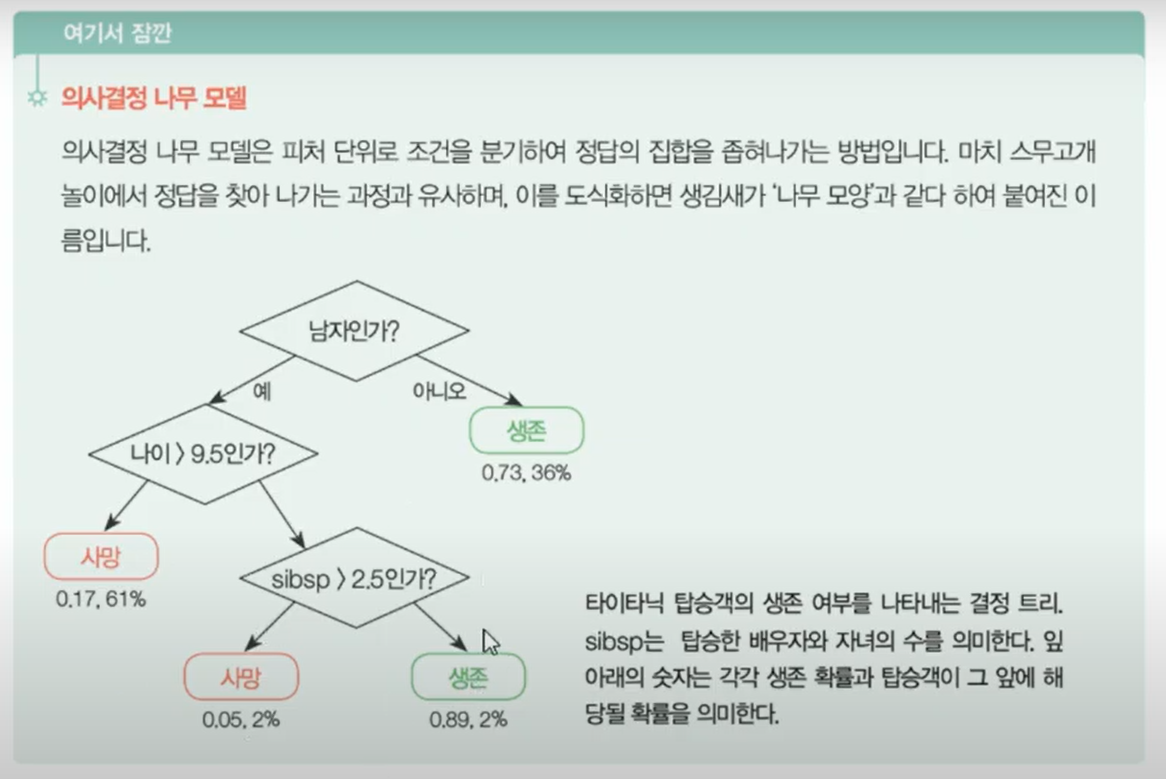

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 의사결정나무를 학습하고, 학습한 모델로 테스트 데이터셋에 대한 예측값을 반환합니다.
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1]

# 학습한 모델의 성능을 계산하여 출력합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

In [ ]:
# 학습한 모델의 AUC를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

# <Step3. 모델 개선> : 피처 엔지니어링 첫걸음

### [피처에서 새로운 의미 추출해내기]

In [ ]:
# 데이터를 다시 불러옵니다.
df_train = pd.read_csv("data_titanic_adv/titanic_train.csv")
df_test = pd.read_csv("data_titanic_adv/titanic_test.csv")
df_train = df_train.drop(['ticket', 'body', 'home.dest'], axis=1)
df_test = df_test.drop(['ticket', 'body', 'home.dest'], axis=1)

In [ ]:
# age의 결측값을 평균값으로 대체합니다.
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

In [ ]:
# embark : 2개의 결측값을 최빈값으로 대체합니다.
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

In [ ]:
# one-hot encoding을 위한 통합 데이터 프레임(whole_df)을 생성합니다.
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

##### cabin 피처 활용하기

In [ ]:
print(whole_df['cabin'].value_counts()[:10])

In [ ]:
# 결측 데이터의 경우는 ‘X’로 대체합니다.
whole_df['cabin'] = whole_df['cabin'].fillna('X')

# cabin 피처의 첫 번째 문자를 추출합니다.
whole_df['cabin'] = whole_df['cabin'].apply(lambda x: x[0])

In [ ]:
whole_df['cabin'].value_counts()

In [ ]:
# 추출한 문자 중, G와 T는 수가 너무 작기 때문에, 마찬가지로 ‘X’로 대체합니다.
whole_df['cabin'] = whole_df['cabin'].replace({"G":"X", "T":"X"})

ax = sns.countplot(x='cabin', hue = 'survived',  data = whole_df)
plt.show()

##### name 피처 활용하기

In [ ]:
# 이름에서 호칭을 추출합니다.
name_grade = whole_df['name'].apply(lambda x : x.split(", ",1)[1].split(".")[0])
name_grade = name_grade.unique().tolist()
print(name_grade)

In [ ]:
# 호칭에 따라 사회적 지위(1910년대 기준)를 정의합니다.
grade_dict = {'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직을 나타냅니다.
              'B': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성을 나타냅니다.
              'C': ['Jonkheer', 'the Countess'], # 귀족이나 작위를 나타냅니다.
              'D': ['Mr', 'Don'], # 남성을 나타냅니다.
              'E': ['Master'], # 젊은남성을 나타냅니다.
              'F': ['Miss', 'Mlle', 'Lady']} # 젊은 여성을 나타냅니다.

# 정의한 호칭의 기준에 따라, A~F의 문자로 name 피처를 다시 정의하는 함수입니다.
def give_grade(x):
    grade = x.split(", ", 1)[1].split(".")[0]
    for key, value in grade_dict.items():
        for title in value:
            if grade == title:
                return key
    return 'G'
    
# 위의 함수를 적용하여 name 피처를 새롭게 정의합니다.
whole_df['name'] = whole_df['name'].apply(lambda x: give_grade(x))
print(whole_df['name'].value_counts())

### `[미니 퀴즈 - 4.2]`
- `‘cabin’ 피처와 마찬가지로, ‘name’ 피처에 대해 (생존자/비생존) 그룹 간의 차이를 탐색해 보세요.` 
    - 위와 동일한 방법을 이용하여 생존자와 비생존자 그룹간의 분포가 어떻게 다른지, 시각적으로 탐색해보도록 합시다.
        - 동일한 countplot으로 아래처럼 시각화가 가능합니다.
        - 두 그룹간의 '평균'값의 차이를 검정한 t-test와 같이, 두 그룹간의 '분포'의 차이를 검정하는 방법에는 '카이제곱 검정' 이라는 방법이 있습니다.
        - 카이제곱 검정의 실행 결과, p-value 0.000으로 두 그룹간의 분포가 통계적으로 유의미하게 다르다는 것을 알 수 있습니다.
            - `이에 대한 결과도 아래에 포함하였습니다.`

In [ ]:
ax = sns.countplot(x='name', hue = 'survived',  data = whole_df)
plt.show()

- 카아제곱검정 : https://junsik-hwang.tistory.com/23

In [ ]:
from scipy.stats import chi2_contingency

obs = pd.DataFrame({'생존': whole_df[whole_df['survived']==1]['cabin'].value_counts().sort_index().values, 
                    '사망': whole_df[whole_df['survived']==0]['cabin'].value_counts().sort_index()})
obs.index = ['A', 'B', 'C', 'D', 'E', 'F', 'Z']
chiresult = chi2_contingency(obs, correction=False)

# 카이제곱 통계량이 125 정도로 자유도 2의 3배인 6보다 훨씬 큰 값을 가지고 있고, 
# p-value 또한 0에 가까운 값이기 때문에 생존여부는 관련이 많이 있다고 분석해 볼 수 있다.
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

- 과학적기수법 : https://financedata.github.io/posts/pandas-display-format.html

##### one-hot encoding

In [ ]:
# pandas 패키지를 이용한 one-hot 인코딩을 수행합니다.
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

In [ ]:
df_test.head()

##### 피처 엔지니어링이 완료된 데이터셋 학습

In [ ]:
# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리합니다.
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

In [ ]:
y_test

In [ ]:
# 로지스틱 회귀 모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

In [ ]:
# 학습한 모델의 테스트 데이터셋에 대한 예측 결과를 반환합니다.
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

In [ ]:
# 테스트 데이터셋에 대한 accuracy, precision, recall, f1 평가 지표를 각각 출력합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred)) # AUC (Area Under the Curve) & ROC curve

In [ ]:
# AUC (Area Under the Curve)를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

In [ ]:
# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

### [피처 영향력 살펴보기]

In [ ]:
# 예측 대상인 survived 피처를 제외한 모든 피처를 리스트로 반환합니다. (그래프의 y축)
cols = df_train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

# 각 피처별 회귀 분석 계수를 그래프의 x축으로 하여, 피처 영향력 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coef')
ax.set_title("Each Feature's Coef")

plt.show()

# <Step4. 평가> : 모델 검증하기

### [K-fold 교차 검증 수행하기]

참고 : [K Folds Cross Validation Method](https://nonmeyet.tistory.com/entry/KFold-Cross-Validation%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D-%EC%A0%95%EC%9D%98-%EB%B0%8F-%EC%84%A4%EB%AA%85)

- K-fold 교차 검증을 통한 과적합 검증

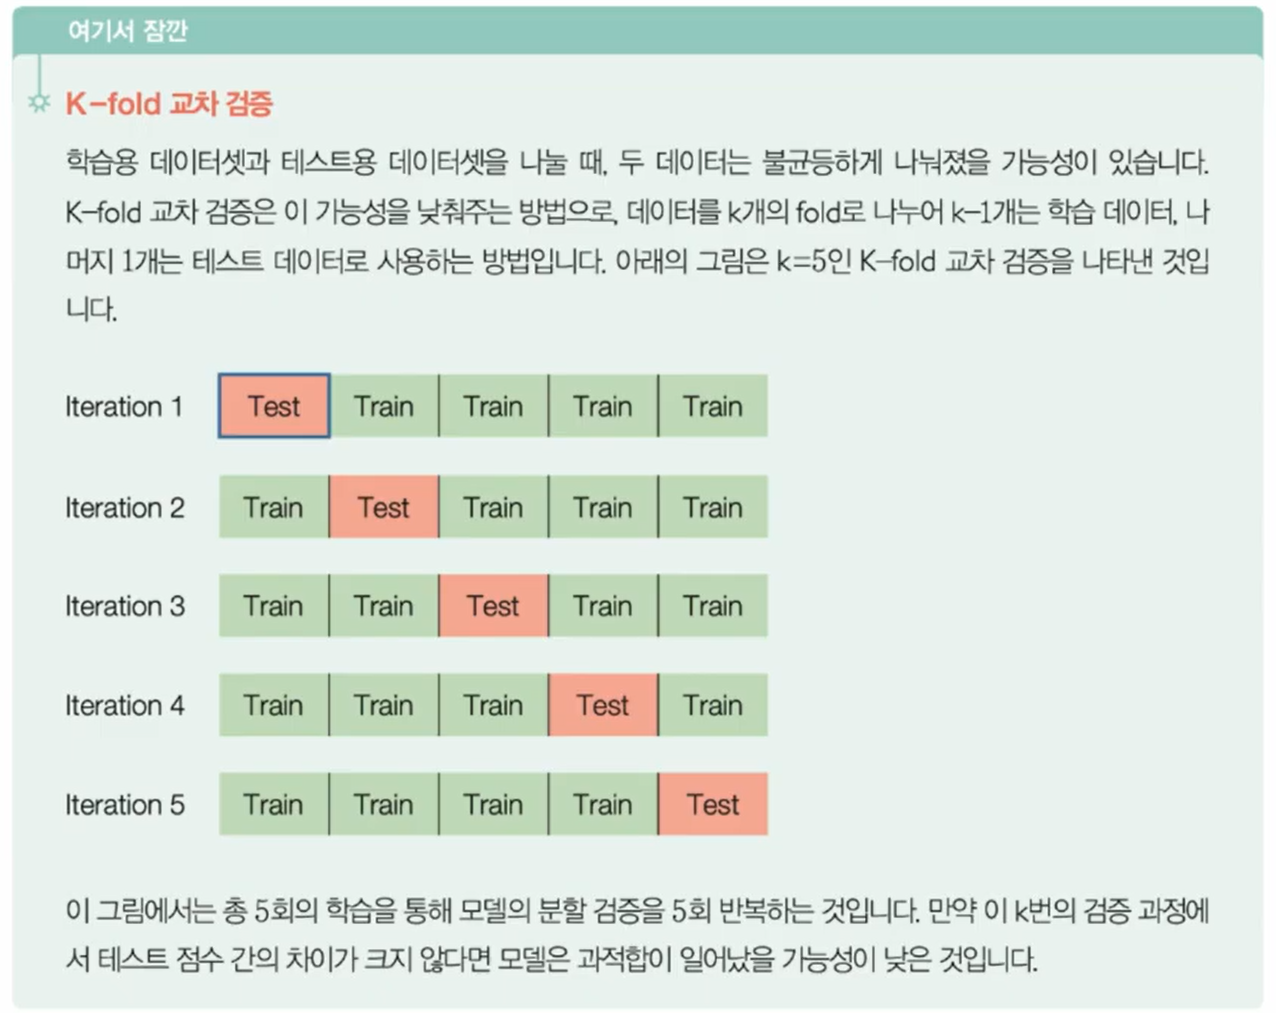

In [ ]:
from sklearn.model_selection import KFold

# K-fold 교차 검증의 k를 5로 설정합니다.
k = 5
cv = KFold(k, shuffle=True, random_state=0)
acc_history = []

# K-fold를 5번의 분할 학습으로 반복합니다.
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):

    # 5개로 분할된 fold 중 4개를 학습 데이터셋, 1개를 테스트 데이터셋으로 지정합니다. 매 반복시마다, 테스트 데이터셋은 변경됩니다.
    df_train = whole_df_encoded.iloc[train_data_row]
    df_test = whole_df_encoded.iloc[test_data_row]
    
    # survived 피처를 y, 나머지 피처들을 x 데이터로 지정합니다.
    splited_x_train, splited_y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
    splited_x_test, splited_y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values
    
    # 주어진 데이터로 로지스틱 회귀 모델을 학습합니다.
    lr = LogisticRegression(random_state=0)
    lr.fit(splited_x_train, splited_y_train)
    y_pred = lr.predict(splited_x_test)
    
    # 테스트 데이터셋의 Accuracy를 계산하여 acc_history에 저장합니다.
    splited_acc = accuracy_score(splited_y_test, y_pred)
    acc_history.append(splited_acc)

In [ ]:
acc_history

In [ ]:
# acc_history에 저장된 5번의 학습 결과(Accuracy)를 그래프로 출력합니다.
plt.xlabel("Each K-fold")
plt.ylabel("Acc of splited test data")
plt.plot(range(1, k+1), acc_history)

### [학습 곡선 분석하기]

- 학습 곡선은 다양한 길이의 데이터 세트에서 모델을 학습하고 학습 및 테스트 세트 모두에 대해 교차 검증 된 점수 대 데이터 세트 크기의 플롯을 생성 한 결과입니다.


- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지를 설치해 줍니다.
    - (env_name) $ `pip install scikit-plot`

In [ ]:
#!pip install scikit-plot

In [ ]:
# 학습 데이터와 테스트 데이터의 점수가 벌어지는 과적합에 대한 학습곡선 관찰
# 학습 데이터 샘플의 개수가 증가함에 따라 학습과 테스트 두 점수가 어떻게 변화하는지 관찰한 그래프
# 데이터가 300개 이상인 경우에는 과적합의 위험이 낮아진다는 것

import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()